In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF
from gpzoo.gp import GaussianPrior, SVGP, VNNGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(2, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.visium_hne_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


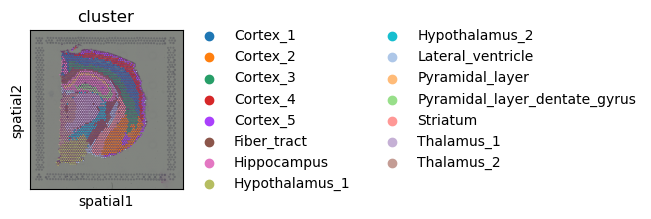

In [4]:
sq.pl.spatial_scatter(adata, color="cluster")

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [6]:
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
Y = np.array(adata.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = adata.obsm['spatial']
X = X.astype('float')
X = rescale_spatial_coords(X)

In [7]:
Y.shape

(11925, 2688)

In [8]:
factors, loadings = regularized_nmf(Y.T, L=10, shrinkage=0.2, max_iter = 100, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=420)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [9]:
moran_idx, moranI = dims_autocorr(factors, X)
# factors=factors[:, moran_idx]
# loadings=loadings[:, moran_idx]

here_andata


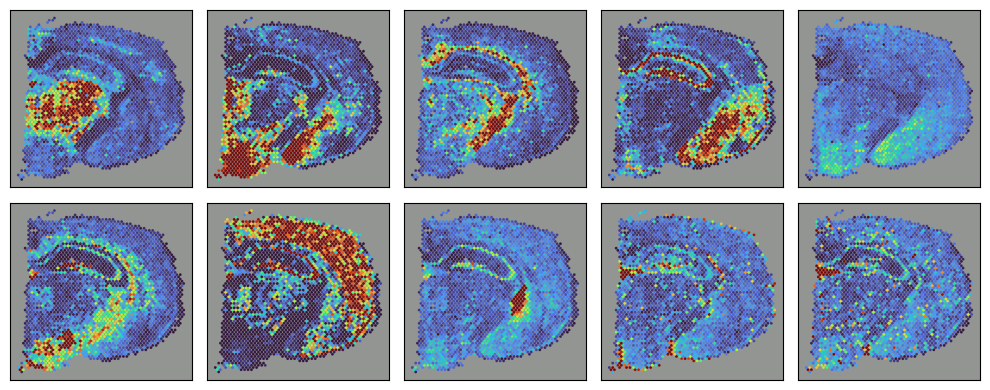

In [10]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx, ax=None, size=2, s=1, alpha=0.9)

In [11]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)

In [12]:
# M = 500
# L = 4
# idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
# kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=0.1)
# all_factors = torch.tensor(factors[:, :L].T)[:, :, None]
# Kzx = kernel.forward(X[idx], X)
# Kzz = kernel.forward(X[idx], X[idx])
# Kxz = torch.transpose(Kzx, -2, -1)
# mu = Kzz@torch.pinverse(Kzx@Kxz) @ Kzx @all_factors

# factors_inter = torch.squeeze(Kxz @ torch.pinverse(Kzz)@mu)
# plot_factors(torch.exp(factors_inter).detach().numpy(), Xtr, moran_idx=None, ax=None, size=2, s=5, alpha=1)

In [27]:
def build_model(Y, M=1000, L=10):
    

    
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    Z = nn.Parameter(X[idx].clone().detach())
    
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=0.1)
    gp = VNNGP(kernel, M=M, jitter=1e-3, K=8)
    Kzx = kernel.forward(Z, X)
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx@Kxz, 1e-4))
    

    solved1 = torch.cholesky_solve(Kzx@all_factors, L1)
    print('solved1 shape:', solved1.shape)
    
    
    mu = Kzz@solved1

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp, Y, L=L)

    model.W = nn.Parameter(torch.tensor(loadings[:, :L]).type(torch.float))    
    
    model.to(device)
    return model

In [28]:
model = build_model(Y, M=1500)

solved1 shape: torch.Size([10, 1500, 1])
here


distances: torch.Size([2688, 1500])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1500])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])


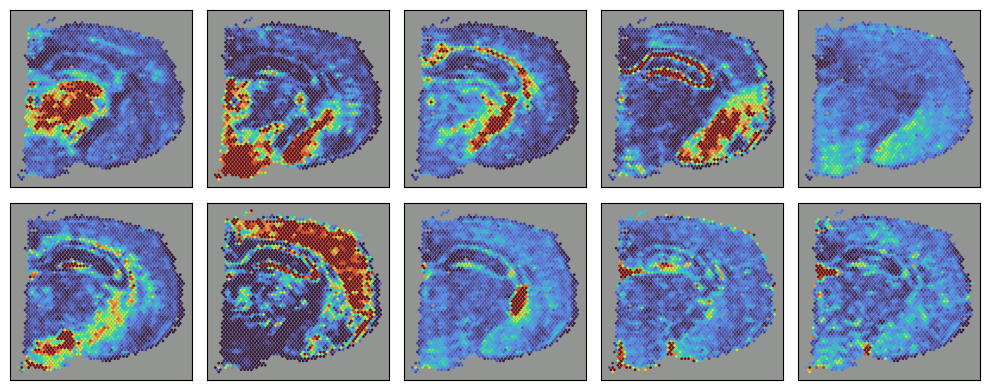

In [29]:
model.cpu()
qF, _, _ = model.prior(X)
mean = torch.exp(qF.mean).detach().numpy()
plot_factors(mean, X, moran_idx=moran_idx, ax=None, size=2, s=1, alpha=0.9)

In [30]:
X_train = X.to(device)
Y_train = Y.to(device)

In [31]:
def model_grads(model):
    model.prior.kernel.sigma.requires_grad = False

    model.prior.kernel.lengthscale.requires_grad = True
    model.prior.Z.requires_grad=False
    model.prior.mu.requires_grad=True
    model.prior.Lu.requires_grad=True
    model.W.requires_grad=True
    
    model.V.requires_grad=False

In [32]:
model_grads(model)

In [33]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [34]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []
    
    means = []
    scales = []
    
    for it in tqdm(range(steps)):
                
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)

        logpY = y*torch.log(pY.rate) - pY.rate
        # logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        KL = distributions.kl_divergence(qU, pU)

        ELBO -= torch.sum(KL)
        
        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales

In [42]:
steps = 1000
model.to(device)

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [43]:
%time losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=steps, E=20)

  0%|          | 0/1000 [00:00<?, ?it/s]

distances: torch.Size([2688, 1500])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1500])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])
distances: torch.Size([2688, 1500])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1500])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])
distances: torch.Size([2688, 1500])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1500])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])
distances: torch.Size([2688, 1500])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1500])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])
distances: torch.Size([2688, 1500])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1500])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([268

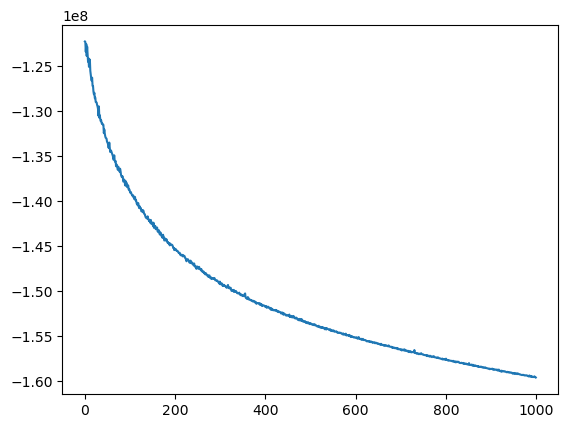

In [44]:
plt.plot(losses)

In [50]:
model.prior.kernel.lengthscale

Parameter containing:
tensor([[[0.4383]],

        [[0.3379]],

        [[0.3577]],

        [[0.3617]],

        [[0.1013]],

        [[0.2195]],

        [[0.0967]],

        [[0.1006]],

        [[0.2138]],

        [[0.3382]]], device='cuda:1', requires_grad=True)

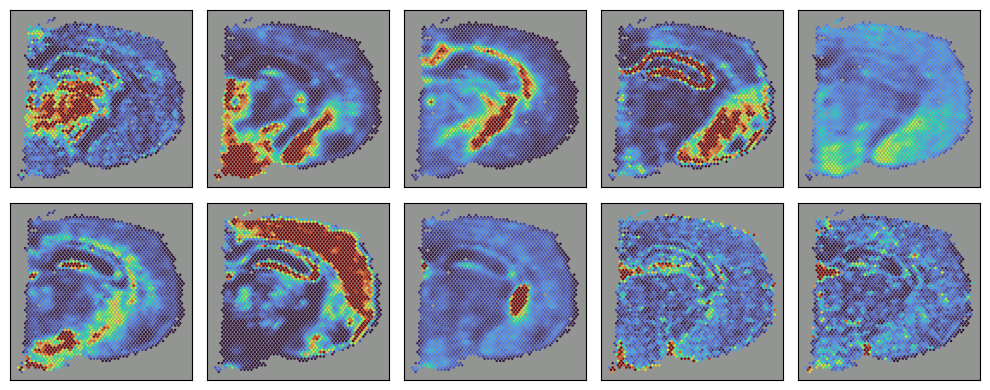

In [58]:
plot_factors(means[-1], X, moran_idx=moran_idx, ax=None, size=2, s=0.6, alpha=1)

In [47]:
# model.cpu()
# Xtest = torch.cartesian_prod(torch.linspace(-2, 2, 34), torch.linspace(-2, 2, 34), )
# qF1, _, _ = model1.sf.prior(Xtest)
# qF2, _ = model1.cf.prior()
# means1_test = torch.exp(qF1.mean).detach().numpy()
# means2_test = torch.exp(qF2.mean).detach().numpy()

In [48]:
# plot_factors(means1_test, Xtest, moran_idx=None, ax=None, size=2, s=5, alpha=1)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99


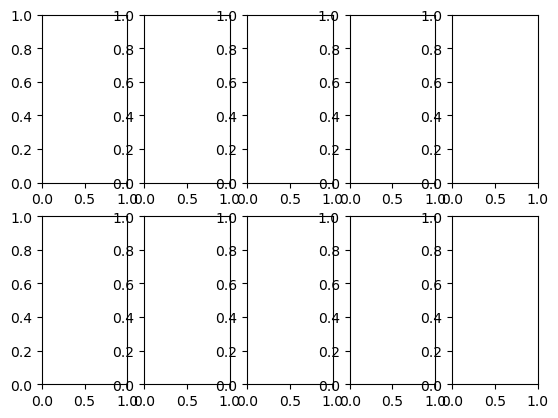

In [59]:
size=2
fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)


def update(iteration):
    for element in ax:
        for element in element:
            element.cla()
        
    curr_factor = means[iteration]

    
    
    plot_factors(curr_factor, X, ax=ax, size=2, s=0.6, alpha=1)

#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 100, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("visium_vnngp.mp4", fps=5, dpi=100)